# Introduction to Artificial Intelligence Final Project
## By Noah Segal-Gould and Tanner Cohan
### K-Means clustering on the most popular Tweets of US congresspeople

#### Import libraries

In [1]:
import numpy as np
import pandas as pd
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter
from glob import glob
from os.path import basename, splitext
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.externals import joblib
from sklearn.manifold import MDS
from IPython.core.display import display, HTML

#### Create lists of file names for all Twitter account CSVs

In [2]:
house_accounts_filenames = glob("house/*.csv")

In [3]:
senate_accounts_filenames = glob("senate/*.csv")

#### Create lists of all dataframes for all CSVs

In [4]:
house_accounts_dataframes = [pd.read_csv(filename).assign(account="@" + splitext(basename(filename))[0]) 
                             for filename in house_accounts_filenames]

In [5]:
senate_accounts_dataframes = [pd.read_csv(filename).assign(account="@" + splitext(basename(filename))[0])
                              for filename in senate_accounts_filenames]

#### Find which n Tweets were most Retweeted and Favorited in each list of dataframes

In [6]:
top_n_tweets = 1

In [7]:
most_retweets_house_accounts_dataframes = [df.sort_values('Retweets').tail(top_n_tweets)
                                           for df in house_accounts_dataframes]
#[df.iloc[[df['Retweets'].idxmax()]] 

In [8]:
most_favorites_house_accounts_dataframes = [df.sort_values('Favorites').tail(top_n_tweets)
                                            for df in house_accounts_dataframes]
#[df.iloc[[df['Favorites'].idxmax()]]

In [9]:
most_retweets_senate_accounts_dataframes = [df.sort_values('Retweets').tail(top_n_tweets)
                                            for df in senate_accounts_dataframes]
#[df.iloc[[df['Retweets'].idxmax()]]

In [10]:
most_favorites_senate_accounts_dataframes = [df.sort_values('Favorites').tail(top_n_tweets)
                                             for df in senate_accounts_dataframes]
#[df.iloc[[df['Favorites'].idxmax()]]

#### Create dataframes of the most Retweeted and Favorited Tweets for each account

In [11]:
most_retweets_congress_dataframe = pd.concat(most_retweets_house_accounts_dataframes + most_retweets_senate_accounts_dataframes).reset_index(drop=True)

In [12]:
most_favorites_congress_dataframe = pd.concat(most_favorites_house_accounts_dataframes + most_favorites_senate_accounts_dataframes).reset_index(drop=True)

#### Show the Retweets dataframe

In [13]:
most_retweets_congress_dataframe.sort_values('Retweets').tail()

,Text,Date,Favorites,Retweets,Tweet ID,account
208,56 years ago today I was released from Parchma...,2017-07-07 13:17:53,259935,114910,883314124863700995,@repjohnlewis
440,Retweet if you care about @realDonaldTrump's t...,2017-01-11 16:40:05,45713,123593,819222357214658561,@RonWyden
468,"Hey Republicans, don't worry, that burn is cov...",2017-03-24 19:53:43,310324,143726,845363015222542336,@SenatorMenendez
450,It's a shame the White House has become an adu...,2017-10-08 15:13:43,419380,148639,917045348820049920,@SenBobCorker
424,"President Trump, you made a big mistake. By tr...",2017-01-21 22:15:24,972101,452896,822930622926745602,@SenSanders


#### Show total number of Tweets in new dataframe

In [14]:
len(most_retweets_congress_dataframe)

523

#### Show which accounts had too few Tweets 

In [15]:
too_few_retweeted_tweets = [(account, total,) for account, total in Counter(most_retweets_congress_dataframe["account"]).most_common() if total != top_n_tweets]

In [16]:
for account, total in too_few_retweeted_tweets:
    display(HTML("<p><a href='https://twitter.com/" + account[1:] + "' target='_blank'>@" + account + "</a>: " + str(total) + "</p>"))

#### Show the Favorites dataframe

In [17]:
most_favorites_congress_dataframe.sort_values('Favorites').tail()

,Text,Date,Favorites,Retweets,Tweet ID,account
452,The President of the United States just defend...,2017-08-15 21:03:44,221573,82791,897564488475586560,@SenWarren
208,56 years ago today I was released from Parchma...,2017-07-07 13:17:53,259935,114910,883314124863700995,@repjohnlewis
468,"Hey Republicans, don't worry, that burn is cov...",2017-03-24 19:53:43,310324,143726,845363015222542336,@SenatorMenendez
450,It's a shame the White House has become an adu...,2017-10-08 15:13:43,419380,148639,917045348820049920,@SenBobCorker
424,"President Trump, you made a big mistake. By tr...",2017-01-21 22:15:24,972101,452896,822930622926745602,@SenSanders


#### Show total number of Tweets in new dataframe

In [18]:
len(most_favorites_congress_dataframe)

523

#### Show which accounts had too few Tweets 

In [19]:
too_few_favorited_tweets = [(account, total,) for account, total in Counter(most_favorites_congress_dataframe["account"]).most_common() if total != top_n_tweets]

In [20]:
for account, total in too_few_favorited_tweets:
    display(HTML("<p><a href='https://twitter.com/" + account[1:] + "' target='_blank'>" + account + "</a>: " + str(total) + "</p>"))

#### Combine all House of Representatives' accounts, all Senators' accounts, and then combine them together into all Congress accounts

In [21]:
house_dataframe = pd.concat(house_accounts_dataframes)

In [22]:
senate_dataframe = pd.concat(senate_accounts_dataframes)

In [23]:
congress_dataframe = pd.concat([house_dataframe, senate_dataframe]).reset_index(drop=True)

#### Remove columns with missing values

In [24]:
congress_dataframe.dropna(inplace=True)

#### Print some statistics

In [25]:
print("Total number of Tweets for all accounts: " + str(len(congress_dataframe)))
print("Total number of accounts: " + str(len(set(congress_dataframe["account"]))))
print("Total number of house members: " + str(len(set(house_dataframe["account"]))))
print("Total number of senators: " + str(len(set(senate_dataframe["account"]))))

Total number of Tweets for all accounts: 1614703
Total number of accounts: 523
Total number of house members: 423
Total number of senators: 100


#### Get NLTK English stopwords

In [26]:
stopwords = stopwords.words('english')

#### Instantiate SnowballStemmer as stemmer

In [27]:
stemmer = SnowballStemmer("english")

#### Load NLTK's Tweet Tokenizer

In [28]:
tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)

#### Define a function to remove hashtags, mentions, and URLs

In [29]:
def clean_word(word):
    return all([("#" not in word), 
                ("@" not in word), 
                ("." not in word), 
                (word.isalpha()), 
                (word not in stopwords)])

#### Define a function to return the list of stemmed words and the list of tokens which have been stripped of non-alphabetical characters and stopwords

In [30]:
def tokenize_and_stem(text):
    tokens = tokenizer.tokenize(text)
    filtered_tokens = [word for word in tokens if clean_word(word)]
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    tokens = tokenizer.tokenize(text)
    filtered_tokens = [word.lower() for word in tokens if clean_word(word)]
    return filtered_tokens

#### Define a function for getting lists of stemmed and tokenized Tweets

In [31]:
def get_stemmed_and_tokenized_dict(tweets):
    stemmed = []
    tokenized = []
    for tweet in tweets:
        stemmed.extend(tokenize_and_stem(tweet))
        tokenized.extend(tokenize_only(tweet))
    return {"Stemmed": stemmed, "Tokenized": tokenized}

#### Apply function to Tweets

In [32]:
%time stemmed_and_tokenized_dict = get_stemmed_and_tokenized_dict(most_favorites_congress_dataframe["Text"])

CPU times: user 382 ms, sys: 4.55 ms, total: 386 ms
Wall time: 443 ms


#### Create a dataframe of stemmed and tokenized words

In [33]:
vocab_frame = pd.DataFrame({'words': stemmed_and_tokenized_dict["Tokenized"]}, 
                           index = stemmed_and_tokenized_dict["Stemmed"])

In [34]:
print("There are " + str(vocab_frame.shape[0]) + " items in vocab_frame")

There are 5385 items in vocab_frame


In [35]:
vocab_frame.tail()

,words
the,the
presid,president
start,start
close,closing
foreign,foreign


#### Set up TF-IDF vectorizer from Scikit Learn and also apply the vectorizer to the Tweets

In [36]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, sublinear_tf=True,
                                   min_df=0.001, stop_words='english',
                                   use_idf=True, tokenizer=tokenize_and_stem)

In [37]:
%time tfidf_matrix = tfidf_vectorizer.fit_transform(most_favorites_congress_dataframe["Text"])

CPU times: user 293 ms, sys: 6.86 ms, total: 300 ms
Wall time: 359 ms


In [38]:
print(tfidf_matrix.shape)

(523, 1615)


In [39]:
terms = tfidf_vectorizer.get_feature_names()

In [40]:
dist = 1 - cosine_similarity(tfidf_matrix)

#### Alternatively set up K-Means clustering

In [41]:
num_clusters = 5

In [42]:
clusterer = KMeans(n_clusters=num_clusters)

In [43]:
%time clusterer.fit(tfidf_matrix)

CPU times: user 487 ms, sys: 12 ms, total: 499 ms
Wall time: 607 ms


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [44]:
clusters = clusterer.labels_.tolist()

#### Save/load the model

In [45]:
joblib.dump(clusterer, 'doc_cluster.pkl')

['doc_cluster.pkl']

In [46]:
#clusterer = joblib.load('doc_cluster.pkl')
#clusters = clusterer.labels_.tolist()

#### Create new dataframe for easy access of accounts which apply to clusters

In [47]:
tweets = {'Account': most_favorites_congress_dataframe["account"], 
          'Text': most_favorites_congress_dataframe["Text"], 
          'cluster': clusters}

In [48]:
frame = pd.DataFrame(tweets, columns = ['Account', 'Text', 'cluster'])

In [49]:
frame.head()

,Account,Text,cluster
0,@RepPeteKing,Masterful speech by @POTUS Trump at UN. Proud ...,2
1,@RepRichHudson,Join me to stop Obama's crusade to restrict ou...,0
2,@RepCurbelo,.@POTUS just doesn't get it. There is no moral...,0
3,@RepTipton,Congrats to @CHS1876 student Tiona Cordova for...,0
4,@RepFredUpton,Let me be clear: There are no 'very fine' whit...,0


#### Number of Tweets per cluster (clusters from 0 to 4)

In [50]:
frame['cluster'].value_counts()

0    316
4     73
1     67
2     46
3     21
Name: cluster, dtype: int64

#### Show the top 10 keywords and the accounts for each cluster

In [51]:
top_n_words = 10

In [52]:
top_n_accounts = 5

In [53]:
top_words_dict = {}

In [54]:
print("Top terms and accounts per cluster:")
print()
order_centroids = clusterer.cluster_centers_.argsort()[:, ::-1] 
for i in range(num_clusters):
    top_words = [vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0] 
                 for ind in order_centroids[i, :top_n_words]]
    top_words_dict[i] = ", ".join(top_words[:4])
    print("Cluster %s words: " % str(i+1) + ", ".join(top_words))
    print("Cluster " + str(i+1) + " top " + str(top_n_accounts) + " accounts:")
    top_accounts = [account for account, value in Counter(frame[frame["cluster"] == i]["Account"]).most_common(top_n_accounts)]
    for account in top_accounts:
        display(HTML("<a href='https://twitter.com/" + account[1:] + "' target='_blank'>" + account + "</a>"))
    print()

Top terms and accounts per cluster:

Cluster 1 words: vote, house, tax, white, statement, colleagues, w, tonight, supporting, needs
Cluster 1 top 5 accounts:



Cluster 2 words: american, care, health, protect, thank, act, people, lives, work, healthcare
Cluster 2 top 5 accounts:



Cluster 3 words: president, america, trump, decision, withdrawing, constitution, make, climate, applaud, action
Cluster 3 top 5 accounts:



Cluster 4 words: mr, resign, sessions, president, ag, speaker, immediately, honor, recuse, work
Cluster 4 top 5 accounts:



Cluster 5 words: today, great, meeting, staff, families, safe, news, thank, please, days
Cluster 5 top 5 accounts:


#### Multidimensional Scaling 2D

In [55]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)

In [56]:
%time pos = mds.fit_transform(dist)

CPU times: user 11 s, sys: 2.41 s, total: 13.4 s
Wall time: 13.6 s


In [57]:
xs, ys = pos[:, 0], pos[:, 1]

### Visualizing document clusters

#### Set up Matplotlib

In [58]:
cluster_colors = {0: '#e6194b', 1: '#3cb44b', 2: '#ffe119', 3: '#0082c8', 4: '#f58231'}

In [59]:
cluster_names = top_words_dict

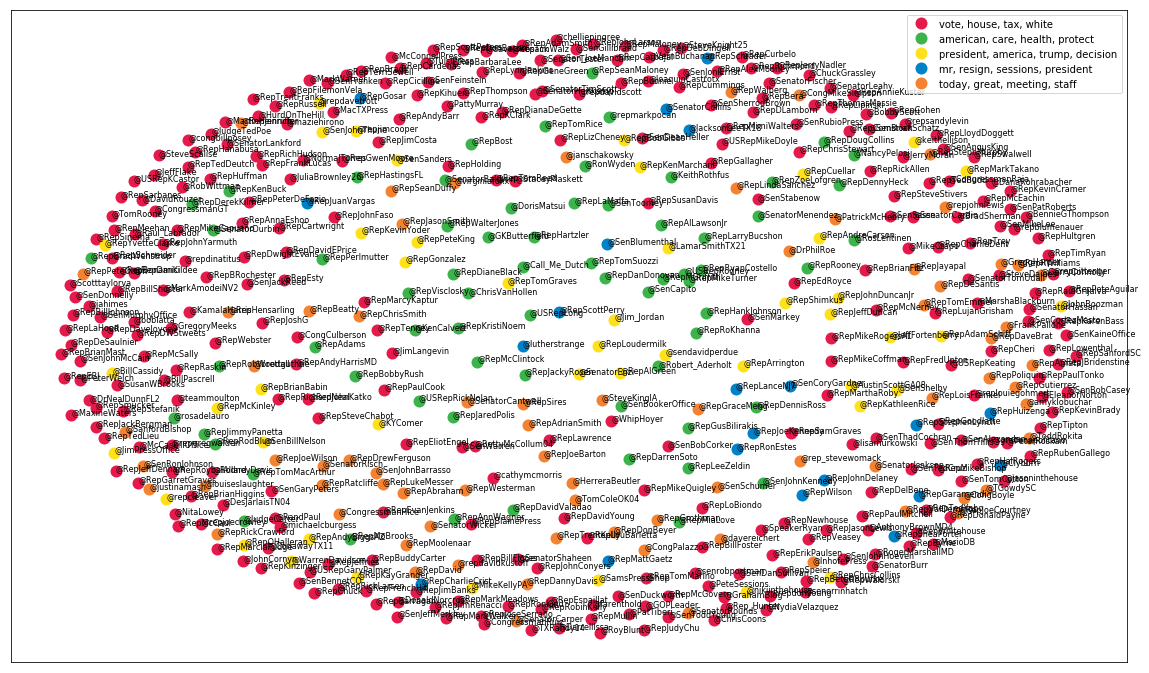

In [60]:
%matplotlib inline 
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=most_favorites_congress_dataframe["account"])) 
groups = df.groupby('label')
fig, ax = plt.subplots(figsize=(20, 12))
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis= 'x', which='both', bottom='off', top='off', labelbottom='off')
    ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')   
ax.legend(numpoints=1)
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  
plt.show()
#plt.savefig('clusters.png', dpi=200)

#### Multidimensional Scaling 3D

In [61]:
mds = MDS(n_components=3, dissimilarity="precomputed", random_state=42)

In [62]:
%time pos = mds.fit_transform(dist)

CPU times: user 9.15 s, sys: 1.15 s, total: 10.3 s
Wall time: 9.18 s


In [63]:
xs, ys, zs = pos[:, 0], pos[:, 1], pos[:, 2]

#### Set up Plotly

In [64]:
plotly.tools.set_credentials_file(username='segalgouldn', api_key='3npOhUHFK0ZcvmfVfIzx')

In [65]:
pd_threed = pd.DataFrame(dict(x=xs, y=ys, z=zs, label=clusters, txt=most_favorites_congress_dataframe["account"]))

In [66]:
pd_threed.head()

,label,txt,x,y,z
0,2,@RepPeteKing,-0.361266,0.456587,0.222695
1,0,@RepRichHudson,0.459474,-0.189654,-0.443676
2,0,@RepCurbelo,-0.606413,0.353496,-0.026679
3,0,@RepTipton,0.139697,-0.454388,0.525542
4,0,@RepFredUpton,0.277121,-0.387059,-0.425203


#### Make the graph

In [67]:
cluster1 = go.Scatter3d(
    x=pd_threed[pd_threed["label"] == 0]["x"]*1000,
    y=pd_threed[pd_threed["label"] == 0]["y"]*1000,
    z=pd_threed[pd_threed["label"] == 0]["z"]*1000,
    mode='markers',
    name=cluster_names[0],
    marker=dict(
        size=10,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8,
        color=[cluster_colors[cluster] for cluster in pd_threed[pd_threed["label"] == 0]["label"]]
    ),
    text=["<a href='https://twitter.com/" + account[1:] + "'>" + account + "</a>" 
          for account in pd_threed[pd_threed["label"] == 0]["txt"]]
)
cluster2 = go.Scatter3d(
    x=pd_threed[pd_threed["label"] == 1]["x"]*1000,
    y=pd_threed[pd_threed["label"] == 1]["y"]*1000,
    z=pd_threed[pd_threed["label"] == 1]["z"]*1000,
    mode='markers',
    name=cluster_names[1],
    marker=dict(
        size=10,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8,
        color=[cluster_colors[cluster] for cluster in pd_threed[pd_threed["label"] == 1]["label"]]
    ),
    text=["<a href='https://twitter.com/" + account[1:] + "'>" + account + "</a>" 
          for account in pd_threed[pd_threed["label"] == 1]["txt"]]
)
cluster3 = go.Scatter3d(
    x=pd_threed[pd_threed["label"] == 2]["x"]*1000,
    y=pd_threed[pd_threed["label"] == 2]["y"]*1000,
    z=pd_threed[pd_threed["label"] == 2]["z"]*1000,
    mode='markers',
    name=cluster_names[2],
    marker=dict(
        size=10,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8,
        color=[cluster_colors[cluster] for cluster in pd_threed[pd_threed["label"] == 2]["label"]]
    ),
    text=["<a href='https://twitter.com/" + account[1:] + "'>" + account + "</a>" 
          for account in pd_threed[pd_threed["label"] == 2]["txt"]]
)
cluster4 = go.Scatter3d(
    x=pd_threed[pd_threed["label"] == 3]["x"]*1000,
    y=pd_threed[pd_threed["label"] == 3]["y"]*1000,
    z=pd_threed[pd_threed["label"] == 3]["z"]*1000,
    mode='markers',
    name=cluster_names[3],
    marker=dict(
        size=10,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8,
        color=[cluster_colors[cluster] for cluster in pd_threed[pd_threed["label"] == 3]["label"]]
    ),
    text=["<a href='https://twitter.com/" + account[1:] + "'>" + account + "</a>" 
          for account in pd_threed[pd_threed["label"] == 3]["txt"]]
)
cluster5 = go.Scatter3d(
    x=pd_threed[pd_threed["label"] == 4]["x"]*1000,
    y=pd_threed[pd_threed["label"] == 4]["y"]*1000,
    z=pd_threed[pd_threed["label"] == 4]["z"]*1000,
    mode='markers',
    name=cluster_names[4],
    marker=dict(
        size=10,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8,
        color=[cluster_colors[cluster] for cluster in pd_threed[pd_threed["label"] == 4]["label"]]
    ),
    text=["<a href='https://twitter.com/" + account[1:] + "'>" + account + "</a>" 
          for account in pd_threed[pd_threed["label"] == 4]["txt"]]
)
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
data = [cluster1, cluster2, cluster3, cluster4, cluster5]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='3d-scatter-congress')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~segalgouldn/0 or inside your plot.ly account where it is named '3d-scatter-congress'
